In [1]:
import os
import time
import imageio
import shutil
import scipy.io
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.image import imread
from scipy.integrate import quad

import solver.conditions as conditions
import solver.utils as utils
import solver.pinn as pinn
import solver.pde as pde
import solver.siren as siren
import solver.geometry as geometry
import solver.timedomain as timedomain
import solver.visualizations as visualizations

import warnings
warnings.filterwarnings("ignore")

### Formulation of problem

In [2]:
def initial_condition_function(x):
    return torch.sin(torch.pi * torch.tensor(x[:, 0])).reshape(-1, 1)

def boundary_condition_function(x, t):
    return torch.sin(torch.pi * torch.tensor(t)).reshape(-1, 1)

def fdm_solver(problem, Nx, Ny, last_only=False):
    Lx, Ly = problem.geom.size()
    T = problem.time.t1
    a = problem.alpha

    dx = Lx / (Nx - 1)
    dy = Ly / (Ny - 1)
    dt = min(dx, dy) ** 2 / (4 * a)

    x = torch.linspace(0, Lx, Nx)
    y = torch.linspace(0, Ly, Ny)
    Nt = int(T / dt)
    t = torch.linspace(0, T, Nt)

    u = torch.zeros((Nt, Nx, Ny))
    initial_xy = torch.stack([x.repeat(Ny), y.repeat_interleave(Nx)], dim=1)
    u[0, :, :] = problem.initial_conditions.initial_func(initial_xy).reshape(Nx, Ny)

    for n in tqdm(range(Nt - 1), desc='Computing'):
        for i in range(1, Nx - 1):
            for j in range(1, Ny - 1):
                u[n + 1, i, j] = u[n, i, j] + a * dt / dx**2 * (u[n, i + 1, j] - 2 * u[n, i, j] + u[n, i - 1, j]) \
                                          + a * dt / dy**2 * (u[n, i, j + 1] - 2 * u[n, i, j] + u[n, i, j - 1])
        boundary_xy = torch.stack([x.repeat(Ny), y.repeat_interleave(Nx)], dim=1)
        
        t_current = torch.full((Ny,), dt * (n + 1))
        u[n + 1, 0, :] = problem.boundary_conditions.boundary_func(boundary_xy[0:Ny], t_current).reshape(Ny)

        t_current = torch.full((Ny,), dt * (n + 1))
        u[n + 1, -1, :] = problem.boundary_conditions.boundary_func(boundary_xy[-Ny:], t_current).reshape(Ny)

        t_current = torch.full((Nx,), dt * (n + 1))
        u[n + 1, :, 0] = problem.boundary_conditions.boundary_func(boundary_xy[::Ny], t_current).reshape(Nx)

        t_current = torch.full((Nx,), dt * (n + 1))
        u[n + 1, :, -1] = problem.boundary_conditions.boundary_func(boundary_xy[Ny-1::Ny], t_current).reshape(Nx)
        
    if last_only:
        return u[-1, :, :]
    else:
        x, y, t = torch.meshgrid(x, y, t)
        u = u.permute(1, 2, 0)
        xy = torch.stack([x.flatten(), y.flatten()], dim=-1)
        t = t.reshape(-1, 1)
        u = u.reshape(-1, 1)
        return xy, t, u

torch.Size([10000, 2]) torch.Size([10000, 1]) torch.Size([10000, 1])
torch.Size([10000, 2]) torch.Size([10000, 1]) torch.Size([10000, 1])
torch.Size([5376, 2]) torch.Size([5376, 1])
torch.Size([961, 2]) torch.Size([961, 1])


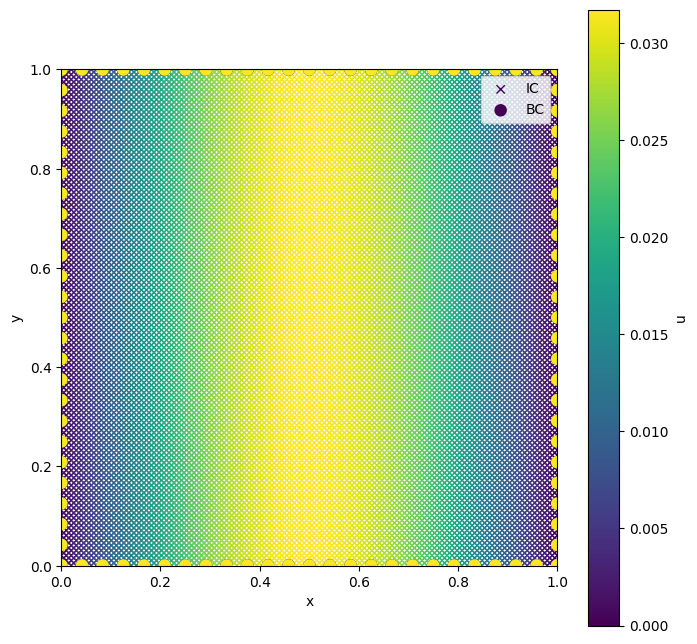

In [3]:
geom = geometry.Rectangle(0.0, 1.0, 0.0, 1.0)
period = timedomain.TimeDomain(0.0, 0.5)

initial_conditions = conditions.InitialConditions()
initial_conditions.set_initial_conditions(geom=geom, time=period, 
                                          initial_func=initial_condition_function, 
                                          num_points=10000, random=False, device="cuda:0")
x, t, u = initial_conditions.get_initial_conditions()
print(x.shape, t.shape, u.shape)

boundary_conditions = conditions.BoundaryConditions()
boundary_conditions.set_boundary_conditions(geom=geom, time=period, 
                                            boundary_func=boundary_condition_function, 
                                            num_points=10000, random=False, device="cuda:0")
x, t, u = boundary_conditions.get_boundary_conditions()
print(x.shape, t.shape, u.shape)

pde_heat = pde.PDE('heat2D', alpha=0.1)

equation = conditions.Equation()
equation.set_equation(pde = pde_heat, geom=geom, time=period, num_points=10000, random=False, device="cuda:0")
x, t = equation.get_equation_points()
print(x.shape, t.shape)

test = conditions.Test()
test.set_test(geom=geom, time=period, num_points=1000, random=False, device="cuda:0")
x, t = test.get_test()
print(x.shape, t.shape)

problem = conditions.Problem(initial_conditions, 
                             boundary_conditions, 
                             equation, test,
                             geom, period, alpha=0.1)

visualizations.conditions_plot(problem, t=0.0)

Computing: 100%|██████████| 479/479 [01:18<00:00,  6.09it/s]


torch.Size([1200000, 2]) torch.Size([1200000, 1]) torch.Size([1200000, 1])


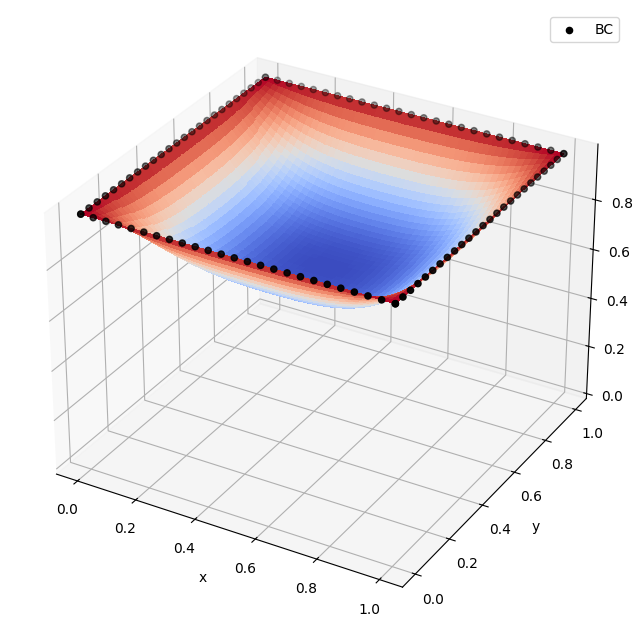

In [15]:
x_initial, t_initial, u_initial = problem.initial_conditions.get_initial_conditions()
x_boundary, t_boundary, u_boundary = problem.boundary_conditions.get_boundary_conditions()

x_equation, t_equation, u_equation = fdm_solver(problem=problem, Nx=50, Ny=50)
solution = conditions.Solution()
solution.set_solution(x_equation, t_equation, u_equation)
print(x_equation.shape, t_equation.shape, u_equation.shape)

visualizations.solution_surface_plot(problem, solution)

### PINN for 2d problem

In [4]:
siren_params = siren.SirenParams(first_omega_0 = 30.0,
                                 hidden_omega_0 = 30.0,
                                 outermost_linear = True)

net_params = utils.NetParams()
net_params.set_params(input=3,
                      output=1,
                      hidden_layers=[int(60) for _ in range(3)],
                      epochs=15000,
                      batch_size=100,
                      lr=0.0001,
                      activation='sin',
                      training_mode='train',
                      regularization=None,
                      lambda_reg=None,
                      optimizer='LBFGS', # 'LBFGS', 'Adam' or 'Hybrid'
                      scheduler=None, # Not applicable with Hybrid optimizer
                      # 'StepLR', 'ExponentialLR', 'ReduceLROnPlateau' is supported
                      early_stopping=False, # Some problem
                      use_rar=False,
                      use_weights_adjuster=False,
                      display_interval=50,
                      model_save_path='models',
                      output_path='out',
                      save_loss=True,
                      initial_weights_path=None, # 'models/model_weights.pth'
                      siren_params=siren_params)

# TODO: Early stopping not work correctly
# Or load from json file
# net_params.from_json_file("params.json")

In [5]:
model = pinn.PINN(problem, net_params, device='cuda:0')
model.training_mode
model.train()
model.save_weights()

2
Activation Function: Sin
Hidden Dimensions: 3
Number of neurons: 60
----------
Layer 0: SineLayer(
  (linear): Linear(in_features=3, out_features=60, bias=True)
) -> SineLayer
Layer 1: SineLayer(
  (linear): Linear(in_features=60, out_features=60, bias=True)
) -> SineLayer
Layer 2: SineLayer(
  (linear): Linear(in_features=60, out_features=60, bias=True)
) -> Linear
Layer 3: Linear(in_features=60, out_features=1, bias=True)
----------
Next number: 2
Oprtimizer: LBFGS
Iteration 50: Loss 0.1783294379711151
Iteration 100: Loss 0.056351080536842346
Iteration 150: Loss 0.04126488044857979
Iteration 200: Loss 0.03340064734220505
Iteration 250: Loss 0.026772769168019295
Iteration 300: Loss 0.022701004520058632
Iteration 350: Loss 0.021774200722575188
Iteration 400: Loss 0.019369829446077347
Iteration 450: Loss 0.017971662804484367
Iteration 500: Loss 0.01697930134832859
Iteration 550: Loss 0.016045430675148964
Iteration 600: Loss 0.015202444978058338
Iteration 650: Loss 0.014289826154708862

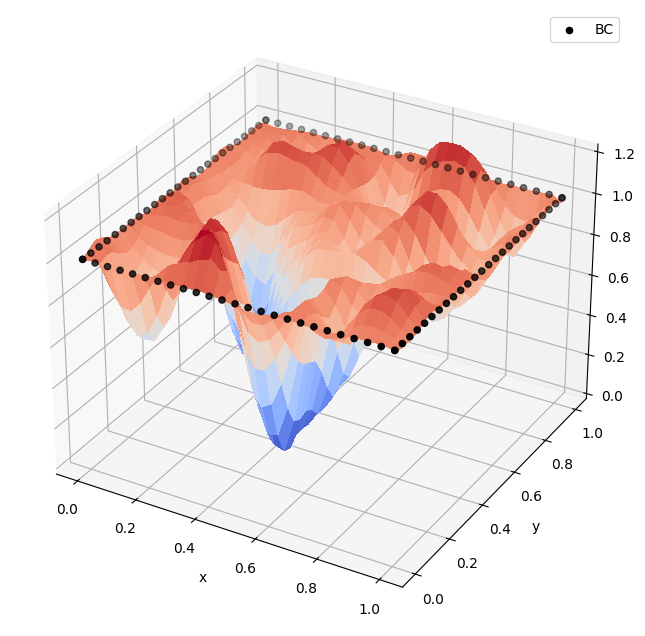

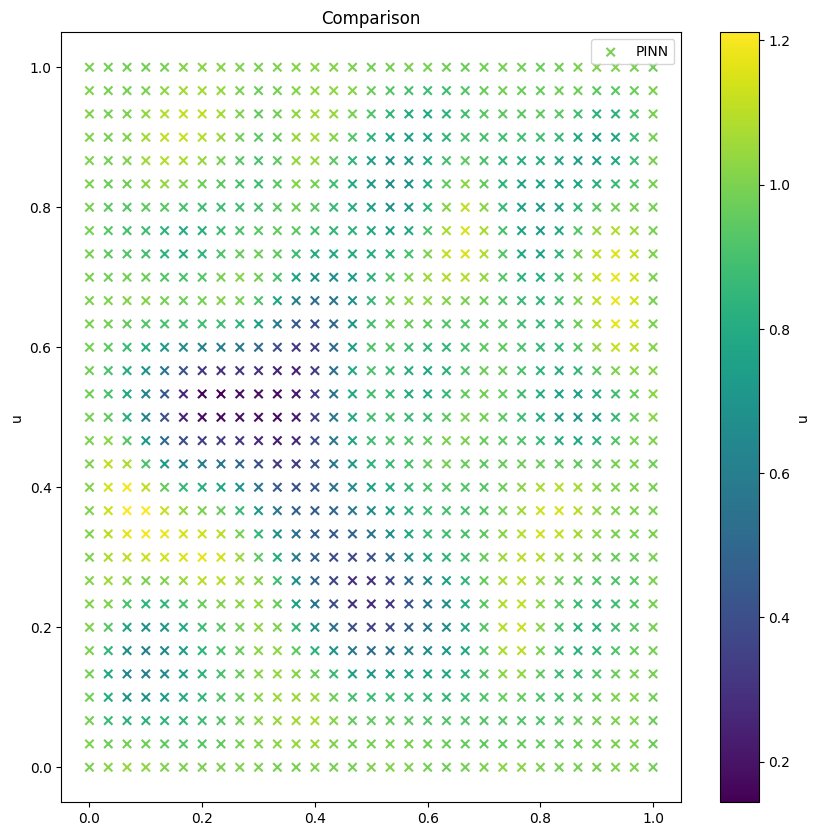

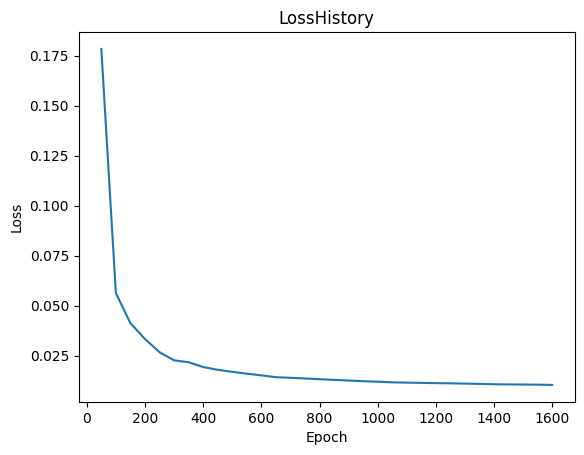

In [6]:
x, t = problem.test.get_test()
u_pinn = model.predict(x, t)

solution_pinn = conditions.Solution()
solution_pinn.set_solution(x, t, u_pinn)

# u_analytical = analytical_solution(problem.test.x.cpu().detach().numpy(), 
#                                    problem.time.t1, problem.alpha, 
#                                    problem.geom.length()).to('cuda:0')
# solution_analytical = conditions.Solution()
# solution_analytical.set_solution(problem.test.x, problem.test.t, u_analytical)

# Plot solution surface
visualizations.solution_surface_plot(problem, solution_pinn)

# Plot of solutions
visualizations.comparison_plot(problem, solution_pinn, None, net_params.output_path)

# Plot loss
visualizations.loss_history_plot(model.get_loss_history(), net_params.output_path)

### Analytical solution for 2D

In [ ]:
def analytical_solution(x, y):
    l_x = 1.0
    l_y = 1.0
    u_1 = 1.0
    u_2 = 5.0
    lambda_n = [n * np.pi / l_x for n in range(1, 52)]
    return (u_1 + (u_2 - u_1) * (x / l_x)
    + 2.0*(u_2 - u_1) * np.sum(1.0 / (n * np.pi * np.sinh(np.sqrt(lambda_n[n]) * l_y)) * (np.sinh(np.sqrt(lambda_n[n]) * y) + pow(-1, n) * np.sinh(np.sqrt(lambda_n[n]) * (l_y - y))) * np.sin(n * np.pi * x / l_x) for n in range(1, 50)))